# Machine Learning Engineer Nanodegree
## Supervised Learning
## Capstone Project: Predicting Blood Glucose Levels for Diabetics using Supervised Learning 

“Supervised learning, in the context of artificial intelligence (AI) and machine learning, is a type of system in which both input and desired output data are provided. Input and output data are labelled for classification to provide a learning basis for future data processing.” [15] Using my Omnipod insulin pump and Dexcom Continuous Glucose Monitor (CGM), I am starting the initial framework for creating an artificial pancreas. 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import median_absolute_error
from scipy.signal import savgol_filter


# Pretty display for notebooks
%matplotlib inline

# Read diabetes data
diabetes_data = pd.read_csv("DiabetesDataRPB.csv")
print "Diabetes data read successfully!"

Diabetes data read successfully!


In [2]:
# Calculate number of students
n_readings = len(diabetes_data["Basal Insulin"])

# Calculate number of features
n_features = len(diabetes_data.keys())

# Print the results
print "Total number of readings: {}".format(n_readings)
print "Number of features: {}".format(n_features)

Total number of readings: 864
Number of features: 6


In [3]:
feature_cols = list(diabetes_data.columns[:])
X_all = diabetes_data[feature_cols]
print "\nFeature values:"
print X_all.head()


Feature values:
   Time  Bolus Taken  Basal Insulin  Carbs Eaten   BG  Basal Carbs (Liver)
0  0.07          0.0       3.749478          0.0  115             1.874739
1  0.15          0.0       3.689807          0.0  109            -0.812239
2  0.23          0.0       3.633855          0.0  106             0.231213
3  0.32          0.0       3.581916          0.0  106             1.748101
4  0.40          0.0       3.534167          0.0  106             1.124226


## I. Definition
### Project Overview
I. Definition
Project Overview
“Supervised learning, in the context of artificial intelligence (AI) and machine learning, is a type of system in which both input and desired output data are provided. Input and output data are labelled for classification to provide a learning basis for future data processing.” [15] Using my Omnipod insulin pump and Dexcom Continuous Glucose Monitor (CGM), I am starting the initial framework for creating an automated and optimized insulin delivery system (referred to as artificial pancreas and AP for the remainder of this paper). (Insert sentence that summarizes how you use supervised learning)
Diabetes Background

A Type 1 Diabetic (T1D) is an individual that has lost some or all the insulin producing beta cells of their pancreatic islets.  These cells are also used to read blood glucose (BG) levels in the blood stream to inform the body if it needs to release insulin or glucagon based on the level.  Therefore, diabetics must monitor their BG by drawing blood from their finger and placing that blood on a test strip for a machine to calculate the BG level.  A second way is to use a Continue Glucose Monitor (CGM).  This is a catheter device that is inserted under the skin in the interstitial fluid and can read a diabetics BG every 5 minutes and output it to a device or your phone.  The finger sticks are still used to calibrate the CGM.  The CGM is a magnificent device that helps diabetics see patterns and trends in their data.  

With the data from the CGM and finger sticks, a diabetic must determine if their BG is high or low and correct their BG by decreasing the BG with insulin or increasing the BG with carbohydrates.  A lot of diabetics control their insulin intake with an insulin pump.  An insulin pump is catheter device that mechanically supplies insulin to the user through a set of pre-programmed settings (basal) and instant programming settings (bolus).  This device is used to simulate the insulin production of the body that diabetics cannot accomplish anymore on their own.  As it can be seen from my description above, life as a diabetic can feel like an eternal game of seesaw.

I am a T1D and have been since 1988.  The medical field has done some amazing things to help me have a healthy life, but it is still extremely hard to maintain a healthy BG.  The American Diabetes Association decided to put more funding into hardware and software that could help diabetics like myself.  “Following the launch of our Artificial Pancreas Project in 2006, our first steps were to support the development of continuous glucose monitors and increasingly sophisticated insulin pumps [1].”  The goal is to find a closed loop system that can measure the BG with a CGM and output the correct amount of insulin from an insulin pump to keep BG levels within the normal range.  This Artificial Pancreas (AP) project is currently being worked on by some amazing groups (TypeZero, Medtronic, BigFoot Biomedical, Beta Biomedical).  These companies are writing algorithms to have the CGM and insulin pumps communicate so the BG can be regulated continuous throughout the day.  In September of 2016, Medtronic has produced the first ever FDA approved AP.

This work is amazing and very important to me.  As an engineer for over 10 years, I am always searching for ways to advance technology.  Therefore, I am writing my own AP algorithms to better understand the system as well as possibly find an algorithm that might prove useful to other AP efforts and can help diabetics in the future.  It should be noted that my methods are not an attempt to duplicate other companies’ work.  I am making my own assumptions and calculations.  If my algorithms are similar to the methods of the previously mentioned companies, it is simply because we approached the problem in similar ways.
As stated above, I am a T1D and the analysis below is designed only to address that illness.  There are numerous studies on T2D, but are outside the scope of this work.
A typical for a diabetic day is like any other non-diabetic: we eat, sleep, and go about our daily routines.  The big difference is, if we eat a meal full of carbohydrates and don’t counteract that meal with the correct insulin dosage, our BG level will increase or decrease.  Increased BG levels are called hyperglycemia, and decreased blood glucose levels are called hypoglycemia.  Both situations are unsafe for diabetics.  The BG data set for the analysis in this report is shown FIgure below:

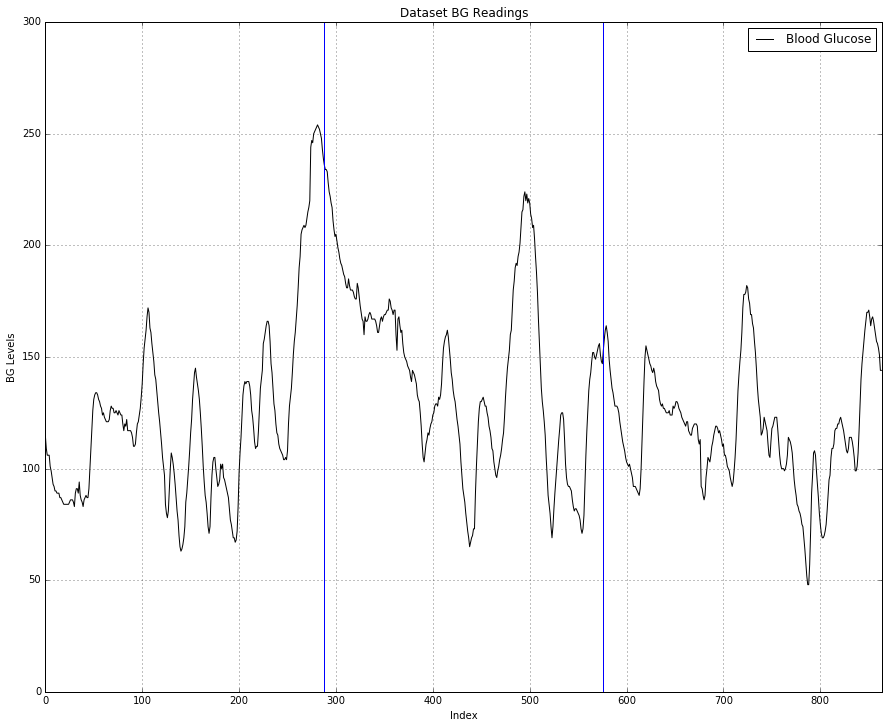

In [4]:
# Visualize data
plt.figure()
plt.figure(figsize=(15,12))
x_scat = range(n_readings)

plt.plot(x_scat, diabetes_data['BG'], c='k', label='Blood Glucose', zorder=1)
plt.axvline(x=288)
plt.axvline(x=576)

plt.xlabel('Index')
plt.ylabel('BG Levels')
plt.axis([0, len(x_scat), 0, 300])
plt.title('Dataset BG Readings')
plt.grid(True)
plt.legend()

Figure 1 - BG Dataset

Hyperglycemia is considered a BG level above 140 mg/dl (milligrams of glucose per deciliter of blood) for an extended period, such as several hours.  Hypoglycemia is considered levels below 70 mg/dl.  BG level within these two limits are considered normal and ideal for a diabetic to maintain.  Diabetics BG levels will fall out of range after meals or during workouts, however, if the BG is return to normal, the damage caused by these states will be minimized.  As seen in Fig. 1, my BG will go into the hyper and hypoglycemic ranges.  It is worth describing how prolonged periods in hypo or hyperglycemia can effect a diabetic.

### Hyperglycemia
Hyperglycemia is an abnormally high blood sugar.  Hyperglycemia BG levels are considered above 140, but typically symptoms are only caused after significantly elevated levels, such as over 200 mg/dl.  Signs of hyperglycemia vary per the individual, but typical symptoms are: frequent urination, increased thirst, headaches, fatigue, and blurred vision.  
If the BG remains high, a diabetic can develop what is known as ketoacidosis, which is a build-up of ketones in the blood and urine.  When a diabetic is in ketoacidosis, the symptoms are: nausea and vomiting, frequent urination, weakness, dry mouth, and sometime diabetics can fall into a coma and sometimes death.  It is common to think that comas are only caused by hypoglycemia, but the reverse is true, just not as frequent.  

It should be noted though hyperglycemia is undesirable, the effects take significant time for the above symptoms to take place.  The remedy for hyperglycemia is to add insulin to reduce the BG.  Frequent episodes of hyperglycemia can also tax other organs and contribute to heart and kidney diseases, diseases of the eyes and circulation issues that could lead to amputation.

### Hypoglycemia
Hypoglycemia is an abnormally low blood sugar. The symptoms that occur in a hypoglycemia state are almost instantaneous.  The body is looking for glucose to perform its normal operations and inadequate glucose is available.  The following are typical signs of hypoglycemia: heart palpitations, fatigue, pale skin, shakiness, irritability, sweating, anxiety, and hunger.  If the hypoglycemia worsens, the signs become: inability to complete routine tasks, blurred vision, seizures, loss of consciousness, and then possibly death.

The remedy for hypoglycemia is to add glucose to the body.  This is typically done by eating, but can be achieve by medicine to stimulate glucose release in the liver.

### Problem Statement
Maintaining a normal BG range is the how and why of a TID.  My program is designed to evaluate several days of blood glucose levels, along with food and insulin intake, and then predict future blood glucose levels to help diabetics or machines make corrections with confidence.

As a diabetic, the BG is dependent on 7 main features:

1) Carbohydrates (C) – Food eaten with carbohydrates increase the BG.  Carbohydrates are rapid digestions and total conversion to glucose.  A carbohydrate works almost immediately and peaks at 45 minutes to an hour.  The final portions of carbohydrates wear off at about 4 hours. 

A typical carbohydrate nutritional absorption looks like Fig. 2:

![alt text](https://raw.githubusercontent.com/rbiven/ArtificialPanc/master/glucoseActivity.jpg "Carb Curves")

Different types of carbohydrates absorb differently.  However, for this analysis, I am assuming only High Glycemic Index (GI) absorption rates based on the foods eaten.  This is a source of noise or error and will be discussed in Reflection.

2) Bolus Insulin (B) – Insulin used as a one-time insertion to counteract the intake of carbohydrates. “It starts working approximately 15 minutes after injection and peaks at approximately 1 hour but continues to work for two to four hours.” [3]  

I am a pump user, so the only type of insulin used in this analysis is rapid-acting and it looks like the next Figure:

![alt text](https://raw.githubusercontent.com/rbiven/ArtificialPanc/master/insulinActivity.jpg "Insulin Curves")

I needed to create two curves that represented the carbohydrate and bolus ingestions over a period of about 4 hours.  I used a Rayleigh curve for the bolus curve and a log-normal distribution for the carbohydrates.  The log-normal was used to get a little more spike in the carbs because after years of experience, the carbohydrates always reacts faster than the bolus if ingested at the same time .  Both curves are normalized so the area under the curve is equal to 1 and can be multiplied by the scalar value of the bolus or the carbohydrate taken.  These two curves together are shown in the next Figure:

![alt text](https://raw.githubusercontent.com/rbiven/ArtificialPanc/master/bolusVCarbs.png "Insulin and Carb Curves")

3) Basal Insulin (BI) – This is a programmed set amount of insulin that is used to counteract the glucose produced by the body to perform normal functions.  The basal rate is programmed in as a step function, meaning the user programs a number of units for a number of hours.  My basal rate program for this analysis is displayed in the table below.

|Time |	Units/hour|
|:---:|:---:|
|12:00AM|	1.05|
|4:00AM	|1.30|
|5:00AM	|1.45|
|6:00AM	|1.30|
|6:30AM	|1.35|
|3:00PM	|1.25|
|6:30PM	|1.40|
|7:00PM	|1.50|
|10:30PM|	1.05|

Insulin is distributed through the body over 4 hours.  Therefore, the bolus curve is used to create the basal insulin for calculations. The daily basals are shown in the next Figure: 

![alt text](https://raw.githubusercontent.com/rbiven/ArtificialPanc/master/dailyBasal.png "Daily Basal Insulin Curve")

4) Basal Glucose (BL) – This is a continually changing feature of the body.  If the body needs to send glucose to the body (brain, nerve, muscle) to perform a simple act, the liver will produce the glucose necessary to do that.  

For a better understanding of features (3) and (4) and how they interact, please see quote from Endocrineweb.com: “Insulin is a hormone made by the pancreas that allows your body to use sugar (glucose) from carbohydrates in the food that you eat for energy or to store glucose for future use. Insulin helps keeps your blood sugar level from getting too high (hyperglycemia) or too low (hypoglycemia).

The cells in your body need sugar for energy. However, sugar cannot go into most of your cells directly. After you eat food and your blood sugar level rises, cells in your pancreas (known as beta cells) are signaled to release insulin into your bloodstream. Insulin then attaches to and signals cells to absorb sugar from the bloodstream. Insulin is often described as a “key,” which unlocks the cell to allow sugar to enter the cell and be used for energy.” [3]

I am looking to solve for this variable in this paper!  However, there are numerous amounts of noise and that will be addressed later in this report. 

![alt text](https://raw.githubusercontent.com/rbiven/ArtificialPanc/master/basalCarbsDR.JPG "Daily Basal Glucose Curve")

It should be noted that the produced regression line might not be identical to the Figure above, but it is worth noting the characteristics.  The line is not discontinuous with large jumps in values, nor does it oscillate in a short period of time.  This makes sense, I do not expect anything in the body to be discontinuous.   

This is the basis for **an assumption I will use throughout this report.**  


#### Assumption 1:
“The body works on a smooth continuous line.  The means no steps in the basal lines or carb and bolus ingestions.  All curves will have a lower order parabolic shape.  It can be assumed that a line that resemble a sine curve with a high frequency is not a normal characteristic either.”

This assumption is very reasonable.  Must diabetics wearing pumps will set their basal rates by fasting for a time and seeing if their BG goes up, down, or remains constant.  Since basal insulin rates are programmed in at constant values, it makes sense that the body will not be jumping around if the diabetic has a constant BI rate and the BG remains constant (and it does when you get it right!).

5) Exercise – Exercise can increase or decrease the BG.  Exercise will decrease the BG by using insulin and glucose more efficiently.  It is possible that adrenaline released by the body for exercise can increase the BG; however, the BG is typically known to dramatically decrease when the adrenaline wears off.  Exercise was not used as a feature in this analysis and is subject of future research.

6) Stress – Stress and mental state can affect the BG.  If a diabetic is under significant stress for a long period, stress hormones can reduce the insulin sensitivity and increase BG.  However, the diabetic data was my own and I was not under unusual stress at the time the data was collected.  Therefore, stress is not used in this analysis.

7) Sickness – during periods of sickness, the body’s hormones and basal rates are not in a normal state because the body is trying to fight off the sickness.  These features could affect the BG; however, I was completely healthy at the time of data collection and this feature will not be used in the analysis .

With these features, the BG would be calculated as:

(1) $$BG_{t1} = BL - BI + C - B +BG_{t0}$$	

In equation (1), $BG_{t1}$ is the predicted blood glucose level to come based on $BG_{t0}$ which is the current BG.  The variable $t1$ is 5 minutes in the future to match the increments of the Dexcom sensor.

However, there are a few other variables that need to be quantified in order for this equation to work.  These variables are completely dependent on the individual diabetic, which mean they vary from person to person.  The variables are:
+ Carb Increase (CI) – This is the amount a single gram of carb will increase a diabetic’s BG.  
+ Insulin Sensitivity Factor (ISF) – This is the amount a single unit of insulin will decrease the user’s BG. 

Therefore, I need to update Eq. (1) with the added variables:

(2) $$ BG_{t1} = (BL+C)*CI - (BI+B)*ISF +BG_{t0}$$ 	

The goal of this project is to find a regression curve for the variable BL. In Equation (2) the only value that is not explicitly given from a device is BL.  With BL generalized from machine learning, I can predict future BG based on the current state I am in, have I eaten carbohydrates or inserted bolus insulin.

I will rearrange Equation (2) to solve for BL:
(3)
$$BL=((BI+B)*ISF-(C*CI)+∆BG)/CI$$ 	
Where: $$∆BG = BG_{t1}-BG_{t0}$$

I can use BL variable in the Equation (2) and predict future BG to compare to the Dexcom.  However, there is a caveat with this calculation that need to be mentioned.  This calculation will incorporate all noise in the system.  The Dexcom is an amazing device with extremely high accuracy, but it is not perfect.  Therefore, let us discuss the Dexcom briefly so we can continue down this path.

I am summarizing information provided on the company website [14].  The Dexcom G4/G5 measures it accuracy by MARD, mean absolute relative differences, for the patients referenced blood glucose measurements.   A lower MARD score represents a closer or better accuracy and Dexcom is the only CGM with a single-digit MARD of 9%.  This makes the Dexcom system very reliable for looking at trends in BG as well as making insulin adjustments if needed.  However, there is some noise or error in the system as seen with the MARD of 9%.  So, by back-calculating the basal sugars the body is producing by using the Dexcom, there is sure to be noise or error in the BL as well.  The noise and error will be discussed at the end.  

These above equations are the basis for the analysis.  The method for how I used these variables features in the machine learning algorithms will be discussed below in greater detail.

## Metric
I used a typical cross-validation for this analysis; however, the score metric is not extremely high.  I hypothesized this because of the dataset size and amount of noise and error.  The current analysis is only using 3 days of data.  As the days go up, the curves get better and better because we are using the median value of the BL value for that time slot.  The dataset also might look like a time series analysis.  This is the case for predicting, but is not necessary true for the fitting and scoring.  By doing all the preprocessing analysis upfront, the dataset becomes BL and time.  Therefore, I will still use the R2, Mean Square Error (MSE), Mean Absolute Error (MAE) values used in previous Udacity work.   

These scores will not be the only metric I look at in this report.  The dataset is from 12/22/2016 to 12/24/2016.  The purpose of this analysis is to be able to predict BG in the future using the created BL values in a day.  Therefore, a second dataset from 1/1/2017 2:00AM until 2:00PM was used for testing the BG with the newly acquired BL values, as well as the carbs and boluses from that time.  The program will predict BG out one hour and score on that.  Equation (2) uses BG at t = 0 as the current time to predict.  I will use the Dexcom value at that time and predict out.  I will use R2, Mean Square Error, and Mean Absolute Error with these predictions.

As you will see throughout this report, noise and error are my biggest issue to overcome.  I think my methodology will demonstrate the basis for how my program will predict.  With more training data and a few more adjustments to bolus and carbohydrate curves, the scores will only get better and better.  This was seen when I initial ran the analysis with 2 days of data.  Three days is better. The BL becomes more realistic with every extra day of data.  However, there is a limit this.  As discussed above, the body is always changing, which means the BL is always changing.  Therefore, 2 weeks is the maximum for data input.  More than two weeks, the body’s BL might different from the starting BL two weeks earlier.  Therefore, I am limiting future data sets to (at most) 2 weeks.

## Exploratory Visualization
My goal is to determine the daily BL for a diabetic user for prediction purposes.  As shown in Equation (3), BL is a back calculation from the other features.  Because of noise in the system, some of the BL values turn up negative while other turned up significantly larger than others.   The assumption of this work is the body is working on a continuous smooth progression and the values will not instantaneously jump up or down, as seen in the data points.  In Figure 1 - BG Dataset, the BG values follow a parametric order over time.  The Dexcom system adds its own smoothing factors [4] to the data that is outside the scope of this work, but I am considering that part of the noise in the system.  Since Dexcom is the most accurate CGM on the market, I am assuming this is the smallest noise I have.  Noise and error will be discussed in greater detail in the Reflection section. 

It is somewhat hard to see how a regression line will fit to Figure showing BL over 3 days. That regression line might be different for each day.  It can be expected that each day’s BL line is different.  We are looking to find a generalization of that BL over the course of the day. Therefore, I am looking at each point in the day as a time slot to receive data.  With this assumption, I took the median  value of the three days and used that for a new BL feature.  By doing this, I am finding a regression line for the most likely of BL values.

In [5]:
#dayBasal = diabetes_data[["Time", "Basal Carbs (Liver)"]].mean(axis=1)

dayBasal =  diabetes_data['Basal Carbs (Liver)'].groupby(diabetes_data['Time']).median()
avgBG    =  diabetes_data['BG'].groupby(diabetes_data['Time']).mean()

df1 = list(dayBasal)
df2 = list(diabetes_data["Time"][:288])
df3 = list(diabetes_data["Basal Insulin"][:288])
df4 = list(avgBG)


columnTitle = ['Time of Day','Basal Insulin','Liver Carbs']
DF = {'Time of Day':df2,'Basal Insulin': df3,'Liver Carbs':df1}
newDF = pd.DataFrame(DF, columns=columnTitle)

day_readings = len(newDF)
print newDF

     Time of Day  Basal Insulin  Liver Carbs
0           0.07       3.749478     1.874739
1           0.15       3.689807     1.757671
2           0.23       3.633855     2.295281
3           0.32       3.581916     1.748101
4           0.40       3.534167     0.328364
5           0.48       3.490684     0.240593
6           0.57       3.451448    -0.002848
7           0.65       3.416362     0.379609
8           0.73       3.385263     0.270615
9           0.82       3.357937    -0.243589
10          0.90       3.334130    -0.346401
11          0.98       3.313562     1.028847
12          1.07       3.295941     1.358323
13          1.15       3.280968     0.949777
14          1.23       3.268348     1.334174
15          1.32       3.257796     0.948525
16          1.40       3.249044     0.478972
17          1.48       3.241842     0.701083
18          1.57       3.235962     0.969248
19          1.65       3.231198     0.797386
20          1.73       3.227369     0.828000
21        

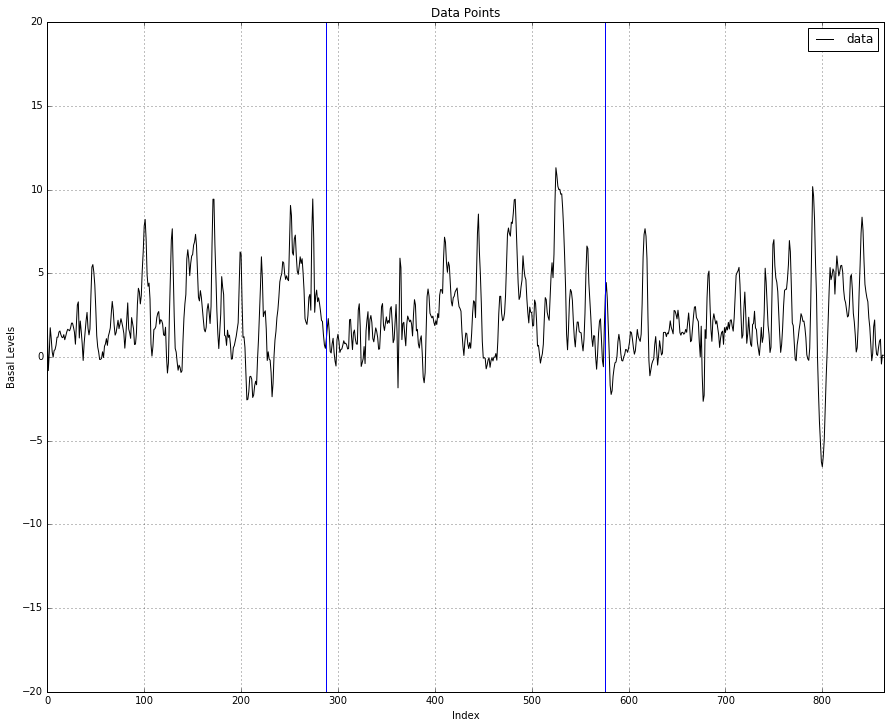

In [6]:
# Visualize data
plt.figure()
plt.figure(figsize=(15,12))
x_scat = range(n_readings)

plt.plot(x_scat, diabetes_data['Basal Carbs (Liver)'], c='k', label='data', zorder=1)
plt.axvline(x=288)
plt.axvline(x=576)

plt.xlabel('Index')
plt.ylabel('Basal Levels')
plt.axis([0, len(x_scat), -20, 20])
plt.title('Data Points')
plt.grid(True)
plt.legend()

When the values of BL are combined using the median of the dataset, it should be noted that the features, Carbs and Bolus, are not the same every day and cannot be combined.  These values are in a time series and are only used to calculate BL.  

## Algorithms and Techniques
Supervised learning can be performed as a classification or regression problem.  My work is using regression because all values fall into the continuous number scale.  The following features are used in the analysis:

Features:

+ Time: Time of day (Continuous)
+ Bolus Taken: number of units of insulin taken at a specific moment in the day (units of insulin) (Continuous); 
+ Basal Insulin: number of units of insulin delivered continuous throughout the day (units of insulin) (Continuous); 
+ Basal Carbs (Liver): amount of glucose liver releases continuously throughout the day (grams) (Continuous); 
+ Carbs Eaten: number of carbohydrates taken at a specific moment in the day (grams) (Continuous);
+ Blood Glucose: BG collected by Dexcom system at 5 minute intervals in the day (Continuous).

Dependent Features:

+ Bolus Ingested: Use `Bolus Taken` to calculate how the body ingests the insulin over a period of time (Continuous)
+ Carbs Ingested: Use `Carbs Eaten` to calculate how the body ingests the carbs over a period of time (Continuous)

The features Carbs Eaten, Bolus Taken, Carbs Ingested, and Bolus Ingested are not used in the machine learning regression.  However, these features are necessary for calculation of Basal Carbs (Liver) and predicting future BG levels.

My future work will also include Activity and Heart Rate as features to help predict BL during times of exercise.  

I used a few regression analyses for the machine learning in this report and the following regression methods were used: 
1)	Decision Tree Regression with AdaBoost - “Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.” [6]

The DT was boosted using the AdaBoost method.  “An AdaBoost regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases.” [7]
Decision trees are simple to understand and interpret and require little data preparation.  One disadvantage of decision trees is they have the tendency to create over-complex trees that do not generalize the data well. 

2)	Support Vector Machine (SVM) using Regression (SVR) – “A support vector machine constructs a hyper-plane or set of hyper-planes in a high or infinite dimensional space, which can be used for classification, regression or other tasks. Intuitively, a good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier.” [8]

SVR is a versatile method which has different Kernel functions for the decision function and it uses a subset of training points in the decision function (the support vectors), so it is also memory efficient.

3)	Gaussian Process Regression (GPR) – “Gaussian Processes (GP) are a generic supervised learning method designed to solve regression and probabilistic classification problems.” [9]
The GPR is advantageous for this work because the predictions interpolate observations and are probabilistic (Gaussian).

Using the scoring methods discussed in the Metric section, I found the following results from the regression (see Table below).  Please note that I could fine-tune the regressors to completely fit the data.  However, as discussed, this will not be a good representation of the body functioning under the assumption of smooth continuous actions.  Therefore, the parameters were set to get a good fit to the data while remember the data is already averaged together by the time of day.  I know there is noise and errors in the data; therefore, I do not want a perfect fit.  The results of the regressor fit are shown in the Implementation section.

In [7]:
# Extract feature columns
feature_cols = newDF.columns[:-1]

# Extract target column 'Basal Carbs (Liver)'
target_col = newDF.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all  = newDF[feature_cols]
y_all  = newDF[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()



Feature columns:
Index([u'Time of Day', u'Basal Insulin'], dtype='object')

Target column: Liver Carbs

Feature values:
   Time of Day  Basal Insulin
0         0.07       3.749478
1         0.15       3.689807
2         0.23       3.633855
3         0.32       3.581916
4         0.40       3.534167


In [8]:
# Import any additional functionality you may need here
from sklearn.model_selection import TimeSeriesSplit
from sklearn import cross_validation

# Set the number of training points
num_train = int(day_readings*0.75)

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, test_size=num_test, random_state=1)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 216 samples.
Testing set has 72 samples.


C:\Users\Ricky\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
def train_regressor(regr, X_train, y_train):
    ''' Fits a regressor to the training data. '''
    
    # Start the clock, train the regressor, then stop the clock
    start = time()
    regr.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_BG(regr, X_all, y_all):
    ''' Makes predictions using a fit classifier based on R2 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = regr.predict(X_all)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return r2_score(y_all, y_pred), mean_absolute_error(y_all, y_pred), mean_squared_error(y_all, y_pred)

def train_predict(regr, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the regressor and the training set size
    print "Training a {} using a training set size of {}. . .".format(regr.__class__.__name__, len(X_train))
    
    # Train the regressor
    train_regressor(regr, X_train, y_train)
    
    r2s_train, mae_train, mse_train = predict_BG(regr, X_train, y_train)
    r2s_test, mae_test, mse_test = predict_BG(regr, X_test, y_test)
    
    # Print the results of prediction for both training and testing
    print "R2 score for training set: {:.4f}.".format(r2s_train)
    print "R2 score for test set: {:.4f}.".format(r2s_test)
    print "Mean Squared Error score for training set: {:.4f}.".format(mse_train)
    print "Mean Squared Error for test set: {:.4f}.".format(mse_test)
    print "Mean Absolute Error score for training set: {:.4f}.".format(mae_train)
    print "Mean Absolute Error for test set: {:.4f}.".format(mae_test)
    

In [10]:
# Import the three supervised learning models from sklearn
# from sklearn import model_B
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
# from skearln import model_C
from sklearn import svm
# from skearln import model_D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Initialize the three models
clf_B = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2),n_estimators=300, random_state=0)
clf_C = svm.SVR(kernel='rbf', C=1e1, gamma=0.2)

kernel = 1.0 * RBF(length_scale=50.0, length_scale_bounds=(1e-1, 1e2)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
clf_D = GaussianProcessRegressor(kernel=kernel, alpha=0.0)

# Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_250 = X_train[:250]
y_train_250 = y_train[:250]

# Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
for size in [100, 200, 250]:
    train_predict(clf_B, X_train[:size], y_train[:size], X_test, y_test)
    print "-------------------------------------------------------"

print "-------------------------------------------------------"
for size in [100, 200, 250]:
    train_predict(clf_C, X_train[:size], y_train[:size], X_test, y_test)
    print "-------------------------------------------------------"
    
print "-------------------------------------------------------"
for size in [100, 200, 250]:
    train_predict(clf_D, X_train[:size], y_train[:size], X_test, y_test)
    print "-------------------------------------------------------"

Training a AdaBoostRegressor using a training set size of 100. . .
Trained model in 0.0400 seconds
Made predictions in 0.0010 seconds.
Made predictions in 0.0010 seconds.
R2 score for training set: 0.5026.
R2 score for test set: 0.3896.
Mean Squared Error score for training set: 1.1315.
Mean Squared Error for test set: 1.3210.
Mean Absolute Error score for training set: 0.8490.
Mean Absolute Error for test set: 0.8977.
-------------------------------------------------------
Training a AdaBoostRegressor using a training set size of 200. . .
Trained model in 0.0270 seconds
Made predictions in 0.0010 seconds.
Made predictions in 0.0010 seconds.
R2 score for training set: 0.4327.
R2 score for test set: 0.3833.
Mean Squared Error score for training set: 1.2135.
Mean Squared Error for test set: 1.3348.
Mean Absolute Error score for training set: 0.8860.
Mean Absolute Error for test set: 0.9003.
-------------------------------------------------------
Training a AdaBoostRegressor using a train

## Tabular Results

** Regressor 1 - AdaBoostRegressor**  

| Training Set Size | Training Time | Prediction Time (test) | R2 Score (train) | R2 Score (test) | Mean Squared Error Score (test) | Mean Absolute Error Score (test) |
| :-----------: | :-------------: | :--------------: | :--------------: | :-------------: | :-------------: | :-----------: |
| 100           |      0.1050     |      0.0020      |      0.5026      |    0.3896       |    1.3210       |    0.8977     |
| 200           |      0.0290     |      0.0010      |      0.4327      |    0.3833       |    1.3348       |    0.9003     |
| 216           |      0.0570     |      0.0010      |      0.4773      |    0.4049       |    1.2880       |    0.8676     |
 
** Regressor 2 - SVR**  

| Training Set Size | Training Time | Prediction Time (test) | R2 Score (train) | R2 Score (test) | Mean Squared Error Score (test) | Mean Absolute Error Score (test) |
| :-----------: | :-------------: | :--------------: | :--------------: | :-------------: | :-------------: | :-------------: |
| 100           |      0.0010     |      0.0010      |      0.5121      |    0.3605       |    1.3841       |    0.9058       |
| 200           |      0.0060     |      0.0020      |      0.4515      |    0.4180       |    1.2597       |    0.8207       |
| 216           |      0.0070     |      0.0020      |      0.4800      |    0.4122       |    1.2722       |    0.8373       |
 
** Regressor 3 - Gaussian Process**  

| Training Set Size | Training Time | Prediction Time (test) | R2 Score (train) | R2 Score (test) | Mean Squared Error Score (test) | Mean Absolute Error Score (test) |
| :-----------: | :-------------: | :--------------: | :--------------: | :-------------: | :-------------: | :-------------: |
| 100           |     1.9590      |      0.0000      |      0.1318      |    0.1923       |    1.7481       |    0.9424       |
| 200           |     4.8530      |      0.0020      |      0.9597      |    0.7982       |    0.4367       |    0.5218       |
| 216           |     0.3730      |      0.0010      |      0.4841      |    0.4216       |    1.2519       |    0.8265       |


## Benchmark
As discussed in Metric, a second dataset from 1/1/2017 2:00AM until 2:00PM was used for testing and benchmarking the analysis.  I will use this dataset to predict the BG with the newly acquired BL value as well as the carbs and boluses from that day.  Equation (2) uses BG at t = 0 as the current time to predict.  I will use the Dexcom value at that time and predict out.  I will use R-squared (R2), Mean Square Error, and Mean Absolute Error with these predictions.
For benchmarking, I am using the R2 value.  “The definition of R-squared is fairly straight-forward; it is the percentage of the response variable variation that is explained by a linear model.  Or:

+ R-squared = Explained variation / Total variation
+ R-squared is always between 0 and 100%:

0% indicates that the model explains none of the variability of the response data around its mean.
100% indicates that the model explains all the variability of the response data around its mean.
In general, the higher the R-squared, the better the model fits your data.” [16]

For my calculation of BL, my benchmark is a R2 value as close to 100%, if the line meets Assumption 1.  Due to the noise, error, and assumptions in the analysis, I am expecting a R2 value to be lower than 100%.  “In some fields, it is entirely expected that your R-squared values will be low. For example, any field that attempts to predict human behavior, such as psychology, typically has R-squared values lower than 50%. Humans are simply harder to predict than, say, physical processes.” [16]  

Therefore, I will use 50% for my BL calculation threshold.  When I use BL calculations to predict future BG, I will set the R2 value to 80% because diabetics’ lives are at stake. 


## Data Preprocessing
The BG (shown in Fig. 1) does have some oscillations that seem to not fit with my assumption of smooth movements.  Therefore, I have added a Savitzky-Golay filter to smooth the BG data. I want lower order curves to prevent the occurrence of a maxima and minima in succession. Because BL is calculated using BG, this will have a smoothing effect on the BL variable as well.

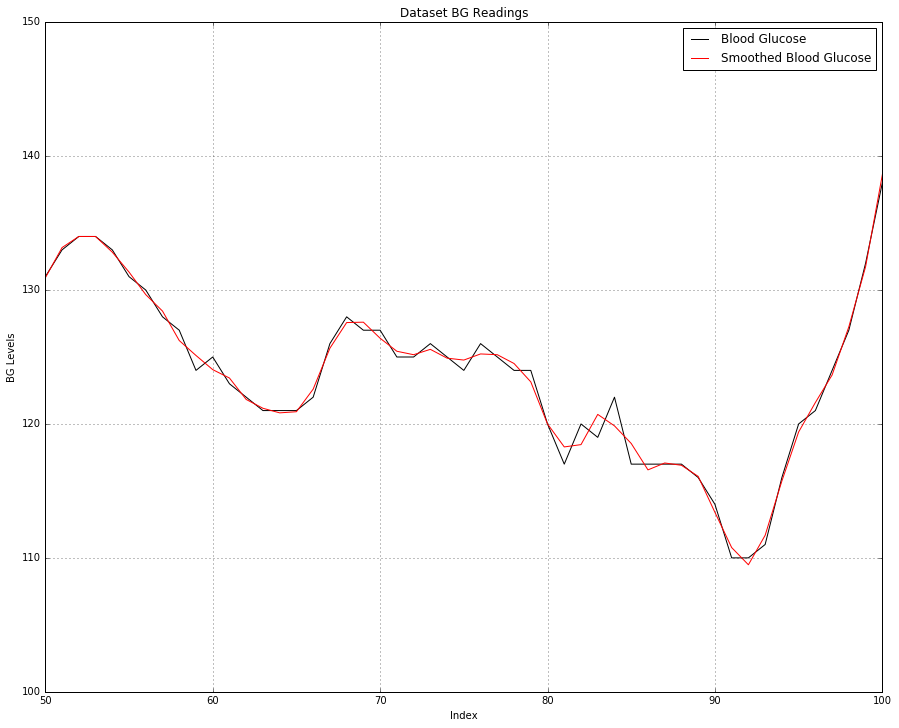

In [11]:
from scipy.signal import savgol_filter
SBG = savgol_filter(diabetes_data['BG'], 5, 2)

# Visualize data
plt.figure()
plt.figure(figsize=(15,12))
x_scat = range(n_readings)

plt.plot(x_scat, diabetes_data['BG'], c='k', label='Blood Glucose', zorder=1)
plt.plot(x_scat, SBG, c='r', label='Smoothed Blood Glucose', zorder=1)
plt.axvline(x=288)
plt.axvline(x=576)

plt.xlabel('Index')
plt.ylabel('BG Levels')
plt.axis([50, 100, 100, 150])
plt.title('Dataset BG Readings')
plt.grid(True)
plt.legend()

## Implementation
The dataset consists of 864 points or three days of data at 5 minute intervals.  This BL data was combined into one day of data which turns into 288 points.  

The regressions were fit to the data using the target feature of BL and the remaining feature: Time and BI.   As discussed above, the other features are in a time series and not adequate for this regression.  Time, BL, and BI are all in the daily repeated form.

As seen in the Algorithms and Techniques section, the regression was performed for the three regression techniques with 100 training points, 200 training points, and 212 training points or 75% of the daily data.  The other 25% was used for testing.  As discussed above, the R2 scores are not above 0.5.  R2 scores range from 1.0 to 0.0, where 1.0 is a perfect fit and 0.0 is no fit at all.  With my scores below 0.5, I looked at a plot of the regressors over the data.  Figures (9-11) show each regressor laid on top of the data.  The y-axis scale is set to give a good visualization.  It becomes harder to see the fit with the data going from top to bottom.  The 4th Figure below shows the regressors on top of each other for comparison.

I did not use the out-of-the-box parameter of each regressor.  They were all fine-tuned to fit the data and meet the assumption.  The code used is as follows:

```
ADT = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2),n_estimators=300, random_state=0)
SVR = svm.SVR(kernel='rbf', C=1e1, gamma=0.2)

kernel = 1.0 * RBF(length_scale=50.0,length_scale_bounds=(1e-1, 1e2)) + WhiteKernel(noise_level= 1e-5, noise_level_bounds=(1e-10, 1e+1))
GPR = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
```

1)	The decision tree with AdaBoost (ADT) was only used with a max_depth=2.  “If the maximum depth of the tree is set to `None`, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples” [6].  As discussed above, this value was kept to 2 to prevent overfitting and recognizing there is noise in the data.  This parameter allowed the regression curve to not overfit the data.

2)	The SVR used the standard RBF kernel, which is a Radial Basis Function kernel.  The RBF is a “real-valued function whose value depends only on the distance from the origin.  Sums of radial basis functions are typically used to approximate given functions. This approximation process can also be interpreted as a simple kind of neural network.” [10] The parameters gamma and C were also changed in this analysis. 

The C parameter trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly by giving the model freedom to select more samples as support vectors 

When gamma is very small, the model is too constrained and cannot capture the complexity or “shape” of the data. The region of influence of any selected support vector would include the whole training set. The resulting model will behave similarly to a linear model with a set of hyperplanes that separate the centers of high density of any pair of two classes.

Smooth models (lower gamma values) can be made more complex by selecting a larger number of support vectors (larger C values) hence the diagonal of good performing models” [11].  

These parameters were adjusted to meet my assumption requirement.

3)	The GPR has two basic parameters to fine tune, kernel and alpha.  Alpha has a default value of 1e-10 and I used a value of 0.0.  The larger the value of alpha corresponds to increase noise level in the observations and reduces the potential numerical issues during fitting [9]. 

I used the White Kernel for the kernel parameter.  A White Kernel “is as part of a sum-kernel where it explains the noise-component of the signal. Tuning its parameter corresponds to estimating the noise-level” [12]. 


C:\Users\Ricky\Anaconda2\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


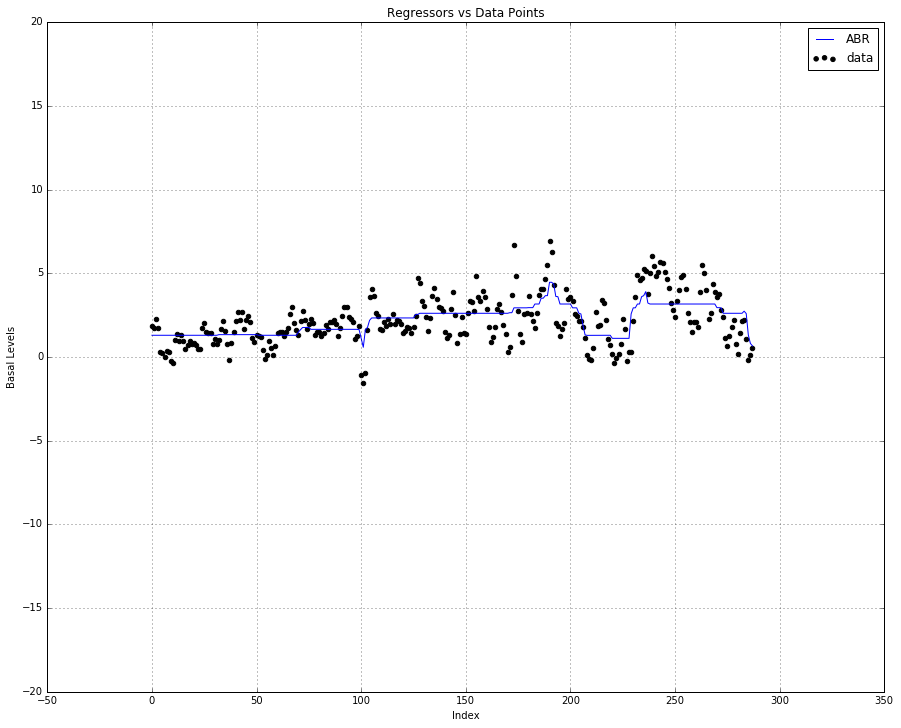

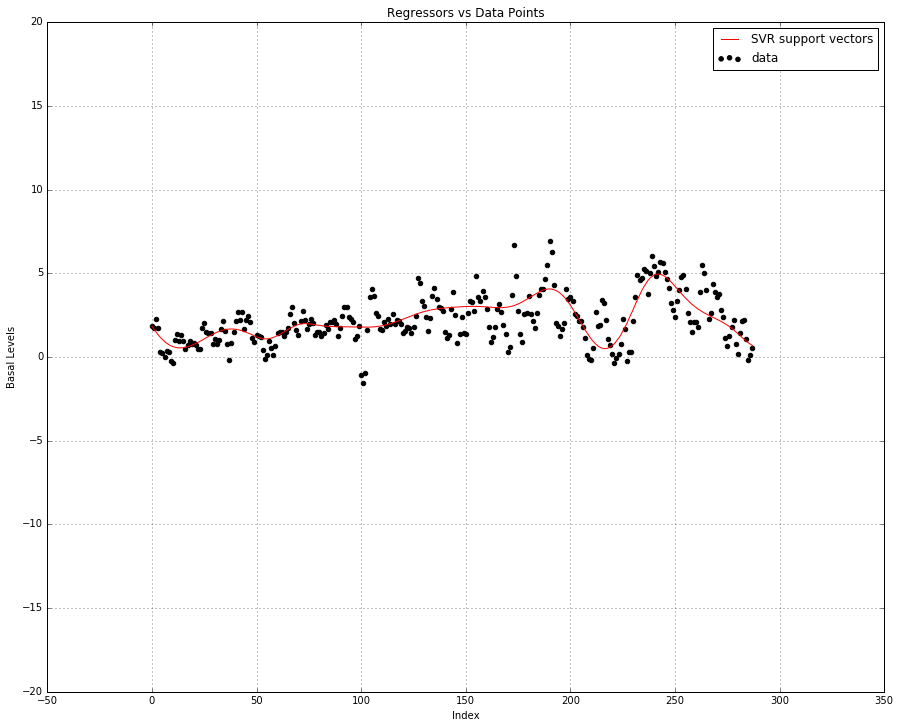

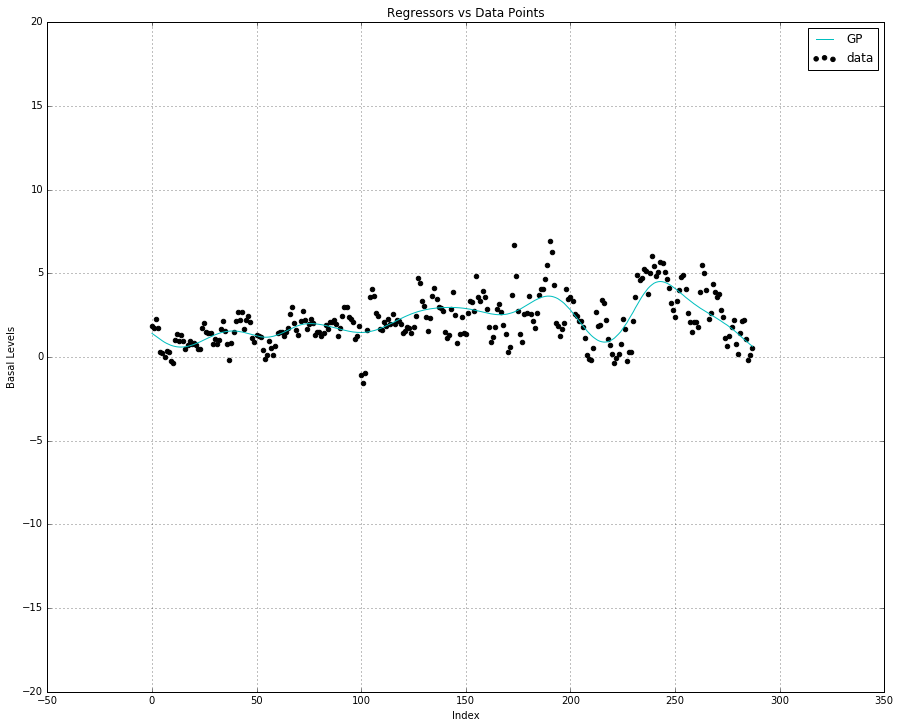

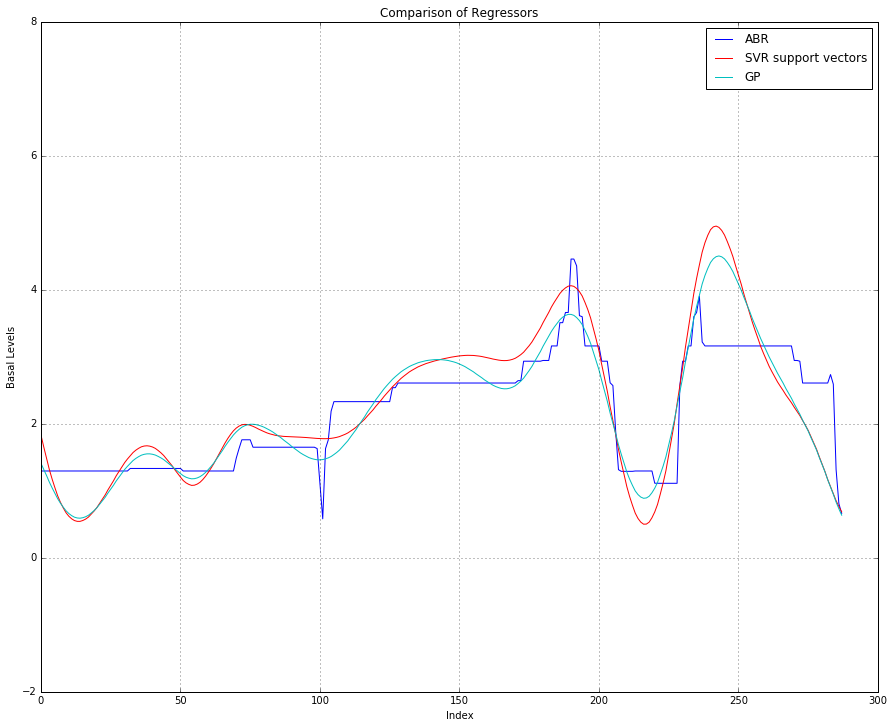

In [12]:
import sklearn.learning_curve as curves
y_pred2 = clf_B.predict(X_all)
y_pred3 = clf_C.predict(X_all)
y_pred4 = clf_D.predict(X_all)

# Visualize data and regression curves
plt.figure()
plt.figure(figsize=(15,12))
x_scat = range(day_readings)

plt.scatter(x_scat, newDF["Liver Carbs"], c='k', label='data', zorder=1)
plt.plot(x_scat, y_pred2, c='b', label='ABR', zorder=2)

plt.xlabel('Index')
plt.ylabel('Basal Levels')
plt.title('Regressors vs Data Points')
plt.ylim([-20,20])
plt.grid(True)
plt.legend()

# Visualize data and regression curves
plt.figure()
plt.figure(figsize=(15,12))
x_scat = range(day_readings)

plt.scatter(x_scat, newDF["Liver Carbs"], c='k', label='data', zorder=1)
plt.plot(x_scat, y_pred3, c='r', label='SVR support vectors',zorder=2)

plt.xlabel('Index')
plt.ylabel('Basal Levels')
plt.title('Regressors vs Data Points')
plt.ylim([-20,20])
plt.grid(True)
plt.legend()

# Visualize data and regression curves
plt.figure()
plt.figure(figsize=(15,12))
x_scat = range(day_readings)

plt.scatter(x_scat, newDF["Liver Carbs"], c='k', label='data', zorder=1)
plt.plot(x_scat, y_pred4, c='c', label='GP',zorder=2)

plt.xlabel('Index')
plt.ylabel('Basal Levels')
plt.title('Regressors vs Data Points')
plt.ylim([-20,20])
plt.grid(True)
plt.legend()

# Visualize data and regression curves
plt.figure()
plt.figure(figsize=(15,12))
x_scat = range(day_readings)

#plt.scatter(x_scat, newDF["Liver Carbs"], c='k', label='data', zorder=1)
plt.plot(x_scat, y_pred2, c='b', label='ABR', zorder=2)
plt.plot(x_scat, y_pred3, c='r', label='SVR support vectors',zorder=2)
plt.plot(x_scat, y_pred4, c='c', label='GP',zorder=2)

plt.xlabel('Index')
plt.ylabel('Basal Levels')
plt.title('Comparison of Regressors')
plt.ylim([-2,8])
plt.grid(True)
plt.legend()
plt.show()

By looking at each of the regressors to the data, it appears as if the regressors capture the data well.  The SVR and GPR also follow my assumption by being a smooth continuous curve.

As seen in Fig. 12, all three curves follow the data in a similar manner.  I chose the SVR as my choice going forward.  The GPR would have been a good choice, but would drastically change with small adjustments to the parameters.  

## Refinement
In the Implementation section, I sent through the code used for the resulting curves.  If I did not make those adjustments, the regressors would of look the following:

![alt text](https://raw.githubusercontent.com/rbiven/ArtificialPanc/master/noAdj.png "Regressors without refinement - Overfit")

The ABR and GPR regressors appear to overfit to the data.  However, the SVR still maintains a smooth curve as I desired.  This is the reason I used SVR as my regressor.  I made a few adjustments to remove some of the bumps in line.

# IV. Results
## Model Evaluation and Validation
As discussed above, in order to see if this model is viable, I need to run a new analysis with the calculated BL on new data to see if it can predict future BG values.  Therefore, I used my data taken from 1/1/17.  Fig. 13 below shows the results of predicting values 1 hour ahead of a given value from the Dexcom CGM.    


In [13]:
# Read diabetes data test set
diabetes_test_data = pd.read_csv("DiabetesTestDataRPB.csv")
print "Diabetes data read successfully!"

Diabetes data read successfully!


In [14]:
feature_cols = list(diabetes_test_data.columns[:])
X_test = diabetes_test_data[feature_cols]
print "\nFeature values:"
print X_test.head()


Feature values:
   Time  Bolus Taken  Basal Insulin  Carbs Eaten   BG
0  2.07          0.0           3.22            0  292
1  2.15          0.0           3.22            0  289
2  2.23          0.0           3.22            0  291
3  2.32          0.0           3.22            0  285
4  2.40          0.0           3.22            0  294


In [15]:
from basal import Basal 
from bolusTime import bolusTime
from carbCurve import Carbs
from carbCurveTime import CarbTIME

L = len(diabetes_test_data['BG'])      # Length of Dataset
ISF = -36.7346938776   # Insulin Sensitivity Factor - How much one unit of insulin
                       # decreases BG (negative because it decreases BG)
C2R = 2.0              # How much 1 gram of Carbs raises BG level

print "Length of Dataset =", L

# 1 - Bolus
basal, bolus = Basal(1,49) # creates curb for bolus ingestion
Bolus = bolusTime(bolus, 0, 1, L)

# 2 - CARBS
carb = Carbs(0.4, 0.0, L) # carb is calculated for an entire length of L
CarbsT = CarbTIME(carb, 3, 1)

#<---------- 
# Analysis: Part 3 - Bring in Chosen Regressor - SVR 
#<----------

SVR = y_pred3

#<---------- 
# Analysis: Part 3 - Calculate BG 
#<----------
CI = 56                                # Setting index for prediction
CValue = diabetes_test_data['BG'][CI]  # Initialize a value for BG

def create_BG(CValue, diabetes_test_data, L, bolus, carb, SVR, CI):
    # Create array for all the boluses that take place
    TB = [] # Total boluses combined from ingestion
    x = 0
    for x in range(L):
        TB.append(bolusTime(bolus, x, diabetes_test_data["Bolus Taken"][x], L))
        x += 1 
    TB = np.array(TB)
    TB = sum(TB)
    
    # Create array for all the Carbs that take place
    TC = []
    for x in range(L):
        TC.append((CarbTIME(carb, x, diabetes_test_data["Carbs Eaten"][x])))
        x += 1
    TC = np.array(TC)
    TC = sum(TC)
    
    # Create array for BG - Target!
    DFL = np.array(SVR)
    DFB = np.array(diabetes_test_data["Basal Insulin"])
    DFB = DFB * -1       # Values decrease blood glucose
    DFL = DFL * C2R
    TC  = TC * C2R
    TB  = TB * ISF
    
    # Predict 1 hour of BG values from CValue
    hr = 60/5
    
    BG = []
    BG.append(CValue)
    
    z = 1
    x = CI+1
    y = CI+hr
    while x < y:
        BG.append(BG[z-1] + DFL[x] + DFB[x] + TC[x] + TB[x])
        x += 1
        z += 1
  
    return BG

# Creating a plot for projected BG versus actual
timeArray = range(0,132,12)

PredBGA = []
for x in range(len(timeArray)):
    Pred_BG = create_BG(diabetes_test_data['BG'][timeArray[x]], diabetes_test_data, L, bolus, carb, SVR, timeArray[x])
    PredBGA.append(Pred_BG)
    END =  timeArray[x] + (60/5)
    Real_BG = list(diabetes_test_data['BG'][timeArray[x]:END])
    print "Mean Square Error   =", mean_squared_error(Real_BG, Pred_BG)
    print "Mean Absolute Error =",mean_absolute_error(Real_BG, Pred_BG)
    print "R2 Scores =", r2_score(Real_BG, Pred_BG)

import itertools
merged = list(itertools.chain.from_iterable(PredBGA))

Length of Dataset = 145
Mean Square Error   = 32.2811559075
Mean Absolute Error = 4.92550877441
R2 Scores = -2.91616381692
Mean Square Error   = 167.848914318
Mean Absolute Error = 12.1740757758
R2 Scores = -11.8565125861
Mean Square Error   = 70.582436043
Mean Absolute Error = 5.94005748146
R2 Scores = -0.46116601354
Mean Square Error   = 203.934375276
Mean Absolute Error = 12.3347658769
R2 Scores = -0.351553297117
Mean Square Error   = 20.3514994635
Mean Absolute Error = 3.41155753577
R2 Scores = 0.76523144094
Mean Square Error   = 67.8635532211
Mean Absolute Error = 6.38962269007
R2 Scores = 0.820532732244
Mean Square Error   = 492.650407332
Mean Absolute Error = 17.2257548036
R2 Scores = 0.13933955311
Mean Square Error   = 338.565511571
Mean Absolute Error = 10.5912168972
R2 Scores = -1.37740447975
Mean Square Error   = 1317.42431582
Mean Absolute Error = 31.7439953417
R2 Scores = -10.8984634645
Mean Square Error   = 541.97251193
Mean Absolute Error = 15.1050450087
R2 Scores = -1.2

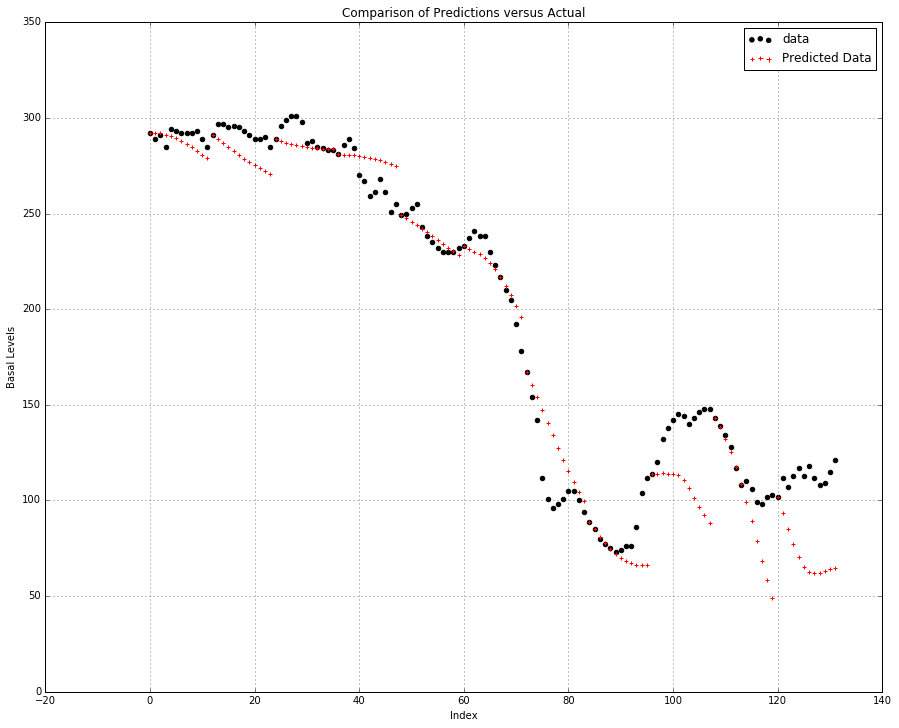

In [16]:
# Visualize data and regression curves
plt.figure()
plt.figure(figsize=(15,12))
x_scat = range(len(merged))

RBG = list(diabetes_test_data['BG'][:len(merged)])

plt.scatter(x_scat, RBG, c='k', label='data', zorder=1)
plt.scatter(x_scat, merged, c='r', marker='+', label='Predicted Data', zorder=1)

plt.xlabel('Index')
plt.ylabel('Basal Levels')
plt.title('Comparison of Predictions versus Actual')
#plt.ylim([-2,8])
plt.grid(True)
plt.legend()
plt.show()

The predicted lines are not exact to the Dexcom data.  The predictions following the curve well at some of the intervals, but not in the others.  This can be seen in the table below.

|Index|	0|	1	|2|	3|	4	|5|	6|	7|	8|	9	|10|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|R2	|-2.92|	-11.9|	-0.46|	-0.35|	0.77|	0.82	|0.14|	-1.3|	-10.9|	-1.2|	-72.1|
|MSE|	32.3|	167.8|	70.6|	203.9|	20.4|	67.9|	492.7|	338.6	|1317|	542.0|	1842|
|MAE|	4.9|	12.2|	5.9|	12.3|	3.4|	6.4|17.2|	10.6|	31.7|	15.1|	39.6|

I find the final model reasonable by not aligning exactly with the expected solution.  I expected the variance from the Dexcom data because of the amount of noise and the fact that I have used a constant bolus and carbohydrate curve throughout the day.  Carbohydrates are a very difficult parameter to model because no carbohydrate is the same.  This can be seen in the Fig. 2.  The same can be said for bolus curves.  As discussed above, ISF is the amount one unit of insulin changes a diabetic’s BG.  This value will vary throughout the day.  There is a lot of variance to this number when exercise and stress are involved in the day.

It should also be mentioned that this above BG readings are a “worst-case” scenario.  The Dexcom system has trouble following the BG when a large change takes place, such as going from 300 mg/dl to 70mg/dl.  Therefore, I will need to run this test data with another set when the BG is not varying as much.  I expect the scores to be better.

With all that said, I am happy with results so far.  However, these results cannot be trusted or used for any type of BG prediction to treat Type 1 Diabetes.  **DO NOT USE THESE RESULTS FOR ANYTHING OTHER THAN ACADEMIC RESEARCH.**

# V. Conclusion
As seen above, the results are a stepping stone in the path to correctly predicting BG in the future.  I will continue this work and add the addition features and functions I have discussed throughout this report.  Again, if you are a diabetic, **DO NOT USE THIS WORK FOR TREATING TYPE 1 DIABETES OR ANY OTHER MEDICAL APPLICATION.**

## Free-Form Visualization
The hardest part of this analysis (and the area of highest error or noise) is the ability to estimate carbohydrates that will be eaten.  This is a difficult task, especially during restaurant visits or holiday parties.  These estimates have a large impact on BG because diabetics must bolus insulin to counteract the carbohydrates in the meals.


## Reflection

The topic of noise and error has continually been mentioned in this report so I want to provide some background.  One error I tried very hard to avoid is a transcription error.  A user can very easily incorrectly transcribe the carbohydrate data into the program.  If I ate a snack and forgot to add it to the input data, this can greatly change the BL variable for that time frame.  

To get the value of carbohydrates from a food, I have to look at the nutritional information provided by the vendor of the food.  All food is not created equal, even if it is the same product.  Therefore, there is a guaranteed error or noise in the input of these values.  

It should also be mentioned that proteins do have effects on BG; however, the effects are not as rapid and can take up to 8 hours for full ingestions.  This is another source of error or noise in the analysis.  

As discussed above, the Dexcom system is very accurate, but not perfect.  Any deviation from the actual BG value is considered noise.  This can be seen whenever there are larger changing in BG, such as after a high concentration of carbohydrates are eaten and the insulin is not adequately bolused.  The Dexcom provides its BG value after smoothing functions and sometimes the results just aren’t the same.  Not shown in this report, a diabetic can take a blood reading and get 225 while the Dexcom says 195.  The trend of the Dexcom is right, but it doesn’t match the blood reading.

One aspect of the analysis I found interesting was the BL results between indices 200-250.  This shows that my body produces almost no glucose and then maxes out within 4 hours.  I think this might be the effect of outliners and not enough data.  But the results are something I will analyze in the future.
The amount of noise affected my results in this report.  As discussed above, the constant ISF, carbohydrate and bolus curves have a large impact on my results.  But even with that said, I am happy with the results and I think the supervised learning technique I used is the right tool for the analysis. I feel once I add the improvements listed below into this analysis, my results will be better and hopefully viable for use.

## Improvement

There are a few aspects I will improve in the future iterations of this program:
1)	More Data.  As discussed above, the BL variable will have some inherent noise associated with it.  I do not think the current data set is large enough at this moment . The noise can be seen when the calculation is complete and the BL value is negative.  This is impossible and unreasonable.  If I add more data, I hope the values at a specific time will begin to represent the most likely value.

2)	I would like to improve in the future is the data collection process.  The dataset for this work was extracted from 3 different sources: 
a)	CGM – The Dexcom G5 outputs its data to one of two devices: the user’s iPhone or Android phone, or the Dexcom Receiver.  Neither of these devices make it easy to download the data and output it to a usable form.  Therefore, to get the data, I sent the data to the Apple Health App and then exported all the Apple health information.  Again, this is no easy task.  The Apple Health data is exported to a .xml file which must be translated to a type that can be used in python.
b)	Omnipod – The insulin delivery system has a similar problem for download.  The pump does not communicate with the user’s phone so the pump needs to be plugged into a computer and the data exported.  The time stamp on this data is in UNIX form which needs to be translated to the same time type used for the CGM.
c)	Carbohydrates – The carbohydrates are manually placed in a text file for the program.

3)	One feature that I did not use that is commonly used in diabetic analysis is the concept of insulin sensitivity changing throughout the day.  This would result in my carbohydrate and bolus curves looking different for different times of day.  I think this is a very realistic feature that I should (and will) add in the future revisions.  However, this will be added to the pre-processing work that will change the values of BL.  Therefore, I should be able to use the same machine learning regression analysis above.

## REFERENCE:

1) https://diatribe.org/issues/26/thinking-like-a-pancreas

2) http://www.medbio.info/horn/time%203-4/homeostasis1.htm

3) https://www.endocrineweb.com/conditions/type-1-diabetes/what-insulin

4) http://web.stanford.edu/~hastie/Papers/gam.pdf

5) https://en.wikipedia.org/wiki/Normal_distribution

6) http://scikit-learn.org/stable/modules/tree.html#tree

7) http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

8) http://scikit-learn.org/stable/modules/svm.html#svm-regression

9) http://scikit-learn.org/stable/modules/gaussian_process.html

10) http://www.livestrong.com/article/178764-caloric-intake-formula/


# Caloric Intake (Post Capstone) - (IN WORK)
This section is looking at the newly created basal glucose versus caloric intake.  I believe there is a correlation.  This comes from numerous experiences in my life in which I took a few weeks (or months) off of training.  Assuming I do not gain weight during this inactive times.  During this time, I will usually get my basal insulin set to a rate that I consider acceptable, meaning it is not pushing my BG out of range by itself.

However, with that said, when I workout for two days in a row at a high intensity, my basal rates become significantly more efficient.  Therefore, I want to see if that activity can help us predict basal levels through a few equations published (Think like a Pancreas).

I have used Livestrong as a reference for this work [10]:

### Resting Energy

Caloric intake equations are based on determining a person's resting energy expenditure. This is the energy necessary to sustain life and to keep the heart, lungs, brain, liver and kidneys functioning properly. According to the book Nutrition Therapy and Pathophysiology, the average North American's resting energy expenditure accounts for about 60 to 75 percent of total daily energy expenditure. The remaining energy expenditure is through physical activity, about 25 percent, and through the metabolic process of digesting food, about 10 percent.

#### Notes:
* Resting = 60-70%
* Physical activity = 25% 
* Digestion = 10%

### Harris-Benedict Equation

The Harris-Benedict equation is one of the most popular equations for determining energy needs by nutrition and health professionals. This equation takes into account a persons sex, age, height, weight and level of physical activity. 

The equation for males is: 

$$66.5 + 13.8 * (Weight \,in \,kg) + 5 * (Height \,in \,cm); 6.8 * age$$ 

The equation for females is: 

$$655.1 + 9.6 * (Weight \,in \,kg) + 1.9 * (Height \,in \,cm); 4.7 * age$$ 

These equations are then multiplied by an energy factor to determining estimated caloric needs. The physical activity factors are: 
* 1.2 for sedentary people 
* 1.3 for moderately active people 
* 1.4 for active people.

### World Health Organization Equation

The World Health Organization (WHO) developed an equation for estimating energy needs in the 1980s. The equation is based on a persons sex, age range and weight. WHO did not feel that height was necessary to include in its equation. The equations are as follows:

#### Females:
* Age 3 to 9 years = 22.5 x (Weight in kg) + 499
* Age 10 to 17 years = 12.2 x (Weight in kg) + 746
* Age 18 to 29 years = 14.7 x (Weight in kg) + 496
* Age 30 to 60 years = 8.7 x (Weight in kg) + 829
* Age over 60 years = 10.5 x (Weight in kg) + 596

#### Males:
* Age 3 to 9 years = 22.7 x (Weight in kg) + 495
* Age 10 to 17 years = 17.5 x (Weight in kg) + 651
* Age 18 to 29 years = 15.3 x (Weight in kg) + 679
* Age 30 to 60 years = 11.6 x (Weight in kg) + 879
* Age over 60 years = 13.5 x (Weight in kg) + 487

Again, these equations are multiplied by the same physical activity factors to estimate daily caloric needs.

### Mifflin-St. Jeor Equation

According to Nutrition Therapy and Pathophysiology, the Mifflin-St. Jeor equation was developed in 1990 and has been validated by more than 10 studies. The Mifflin-St. Jeor equation is gaining popularity among the nutrition professionals for accurately estimating caloric needs. The equation is as follows: 

$$females = 10 * (Weight \,in \,kg) + 6.25 * (Height  \,in \,cm) - 5 * age - 161$$ 
$$males= 10 * (Weight \,in \,kg) + 6.25 * (Height\,in \,cm) - 5 * age + 5$$

These equations are also multiplied by the same physical activity factors to estimate daily caloric needs.

### Which Equation to Choose?

According to the American Dietetic Association, the **Mifflin-St. Jeor equation** has been found to be the most reliable in predicting actual resting energy expenditure within 10 percent. The equation is recommended by nutrition professionals. For further understanding daily caloric intake needs, a Registered Dietitian should be consulted.

In [18]:
# Lets look at this equation with my weight

age           = 33       #[years]
weight        = 97.0     #[kg - 214lbs]
height        = 182.88   #[cm - 6ft]
sex           = 1        #[0 = female, 1 = male]
activityLevel = 0        #[0 = sedentary, 1 = moderately active, 2 = active]


def RE(activityLevel, sex, weight, height, age):
    if activityLevel == 0:
        active = 1.2
    elif activityLevel == 1:
        active = 1.3
    else:
        active = 1.4

    if sex == 0:
        restingEnergy = (10*weight + 6.25*height - 5*age - 161)*active
    else:
        restingEnergy = (10*weight + 6.25*height - 5*age + 5)*active
    
    return restingEnergy

However, in order to see the power of this equation, I need to look at all conditions for the `resting energy`, as well as how the calories vary in respect to weight.  It can be assumed that `height` should not change (besides the normal day compression / expansion at night).  However, as stated above, I am concerned with time periods were a diabetes goes from `sedatary` to `active`.  This could have an effect on weight -- gaining weight by building muscle or losing weight by burning fat.

In [19]:
# Run loop for all conditions
Cweight = weight
loopWeight = [Cweight-2, Cweight-1, Cweight, Cweight+1, Cweight+2]
loopAct = [0,1,2]

for x in range(len(loopWeight)):
    y = 0
    for y in range(len(loopAct)):
        Nweight = loopWeight[x]
        activityLevel = loopAct[y] 
        REC = RE(activityLevel, sex, Nweight, height, age)
        print "Weight: {:.2f}".format(Nweight)
        print "Activity Level: {:.2f}".format(activityLevel)
        print "Resting Energy: {:.2f} calories per day ".format(REC)
        y += 1
    x += 1


Weight: 95.00
Activity Level: 0.00
Resting Energy: 2319.60 calories per day 
Weight: 95.00
Activity Level: 1.00
Resting Energy: 2512.90 calories per day 
Weight: 95.00
Activity Level: 2.00
Resting Energy: 2706.20 calories per day 
Weight: 96.00
Activity Level: 0.00
Resting Energy: 2331.60 calories per day 
Weight: 96.00
Activity Level: 1.00
Resting Energy: 2525.90 calories per day 
Weight: 96.00
Activity Level: 2.00
Resting Energy: 2720.20 calories per day 
Weight: 97.00
Activity Level: 0.00
Resting Energy: 2343.60 calories per day 
Weight: 97.00
Activity Level: 1.00
Resting Energy: 2538.90 calories per day 
Weight: 97.00
Activity Level: 2.00
Resting Energy: 2734.20 calories per day 
Weight: 98.00
Activity Level: 0.00
Resting Energy: 2355.60 calories per day 
Weight: 98.00
Activity Level: 1.00
Resting Energy: 2551.90 calories per day 
Weight: 98.00
Activity Level: 2.00
Resting Energy: 2748.20 calories per day 
Weight: 99.00
Activity Level: 0.00
Resting Energy: 2367.60 calories per day 

|Weight [kg]|	-2 [95kg]|	-1  [96kg]	|Current [97]|	+1 [98kg]|	+2 [99kg]|
|:---:|:---:|:---:|:---:|:---:|:---:|
|RE - Sedentary	       |2319.60|2331.60|2343.60|2355.60|2367.60|
|RE - Moderately Active|2512.90|2525.90|2538.90|2551.90|2564.90|	
|RE - Active           |2706.20|2720.20|2734.20|2748.20|2762.20|	

It can be seen that the difference in activity gives us a linear relationship between each state (ex. Delta RE for current weight for each activity level is: $195.3$. 